In [1]:
# 01 Dec 2016 -- hyr
# Attempt to adjust CE's motion correction toolkit for retinotopy-mapper data.
#
# FIXES:
# Use opencv conda env -- this includes opencv=3.1
# installed with:   conda install -c menpo opencv3=3.1.0


In [1]:

%matplotlib inline

import cv2
import os
import glob
import numpy as np
from scipy import misc,interpolate,stats
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import colors
import time
import shutil

__version__ = '0.3.1'

/home/julianarhee/.local/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
from WiPy import *

In [3]:
# session_dir = '/nas/volume1/widefield/data/JR029W/20161201/JR029W_bar_013Hz'
session_dir = '/nas/volume1/widefield/data/JR040W/20170212/JR040W_bar_013Hz'

session_name = os.path.split(session_dir)[1]
session_date = os.path.split(os.path.split(session_dir)[0])[1]

conditions = [i for i in os.listdir(session_dir) if '_run' in i and 'processed' not in i]
print conditions

['Right_run1', 'Left_run1', 'Bottom_run1', 'Top_run1', 'Blank_run1', 'Left_run2', 'Bottom_run2', 'Top_run2', 'Left_run3', 'Right_run3', 'Right_run2']


In [4]:
#runs_to_correct = ['Left_run1', 'Right_run1']

In [5]:
#def perform_motion_registration(
#sourceRoot,
#targetRoot,
#sessID,
#runList,
refRun=1
saveFrames=True
makeMovies=True
frameRate=60.

sourceRoot = session_dir
targetRoot = os.path.join(session_dir, 'mCorrected')
if not os.path.exists(targetRoot):
    os.makedirs(targetRoot)
sessID = session_date + '_' + session_name

In [6]:
#DEFINE AND MAKE DIRECTORIES
# motionDir=targetRoot+'/Sessions/'+sessID+'/Motion/';
motionDir = os.path.join(targetRoot, 'Motion')

if not os.path.exists(motionDir):
        os.makedirs(motionDir)

motionFileDir = os.path.join(motionDir, 'Registration')
if not os.path.exists(motionFileDir):
    os.makedirs(motionFileDir)

motionFigDir = os.path.join(motionDir, 'Figures')
if not os.path.exists(motionFigDir):
    os.makedirs(motionFigDir)

motionMovieDir = os.path.join(motionDir, 'Movies')
if makeMovies:
    if not os.path.exists(motionMovieDir):
        os.makedirs(motionMovieDir)
    

In [7]:
#OUTPUT TEXT FILE WITH PACKAGE VERSION
outFile=motionFileDir+'analysis_version_info.txt'
versionTextFile = open(outFile, 'w+')
versionTextFile.write('WiPy version '+__version__+'\n')
versionTextFile.close()

In [8]:
def get_reference_frame(sourceRoot,cond,refRun=1):
    #Cesar Echavarria 11/2016
    
    #MAKE SURE YOU GET SOME ARGUMENTS
    if sourceRoot is None:
        raise TypeError("sourceRoot is not defined!")
    if sessID is None:
        raise TypeError("sessID is not defined!")
    
#     runFolder=glob.glob(sourceRoot+sessID+'_run'+str(refRun)+'_*')
#     frameFolder=runFolder[0]+"/frames/"
        
#     imFile=frameFolder+'frame0.tiff'
    
    runFolder = os.path.join(sourceRoot, cond+'_run'+str(refRun))
    fnames = os.listdir(runFolder)
    imFile = os.path.join(runFolder, fnames[0])
    imRef=misc.imread(imFile)
    return imRef

In [10]:
#GET REFFERNCE FRAME
curr_run = conditions[0]
cond = curr_run.split('_')[0]
print cond 

Right


In [11]:

imRef=get_reference_frame(sourceRoot,cond,refRun)
szY,szX=imRef.shape


In [12]:
# run = 'Left_run1'
# os.path.join(motionFileDir, ''.join([sessID, '_run', str(run), '_motionRegistration']))
# motionFileDir

Right
Performing image registration for run: Right
N frames: 9230
Loading frames....
Doing motion registration...
Motion Registration at frame 0 of 9230
Motion Registration at frame 1000 of 9230
Motion Registration at frame 2000 of 9230
Motion Registration at frame 3000 of 9230
Motion Registration at frame 4000 of 9230
Motion Registration at frame 5000 of 9230
Motion Registration at frame 6000 of 9230
Motion Registration at frame 7000 of 9230
Motion Registration at frame 8000 of 9230
Motion Registration at frame 9000 of 9230
7797
Motion Correction at frame 0 of 9230
Motion Correction at frame 1000 of 9230
Motion Correction at frame 2000 of 9230
Motion Correction at frame 3000 of 9230
Motion Correction at frame 4000 of 9230
Motion Correction at frame 5000 of 9230
Motion Correction at frame 6000 of 9230
Motion Correction at frame 7000 of 9230
Motion Correction at frame 8000 of 9230
Motion Correction at frame 9000 of 9230
Getting motion corrected image boundaries...
Applying motion correc

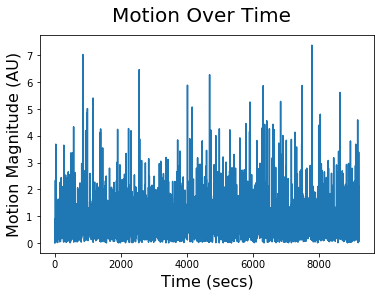

In [13]:


#PERFORM REGISTRATION FOR ALL RUNS
# for (runCount,run) in enumerate(runList):

# runList = runs_to_correct
runList = ['Right_run1']
#runList = ['Top_run1', 'Bottom_run1', 'Top_run2', 'Bottom_run2']
#runList = ['Left_run2', 'Left_run3', 'Right_run2', 'Right_run3']
#runList = ['Left_run1', 'Right_run1']
refRunName = runList[0]

for runCount, run in enumerate(runList):
    
    cond = run.split('_')[0]
    print cond
    
    imRef=get_reference_frame(sourceRoot,cond,refRun)
    szY,szX=imRef.shape

    #print('Performing image registration for run: '+ cond+'_run'+str(run))
    print('Performing image registration for run: '+ cond)

    #runFolder=glob.glob(sourceRoot+sessID+'_run'+str(run)+'_*')
    #frameFolder=runFolder[0]+"/frames/"
    #planFolder=runFolder[0]+"/plan/"
    frameFolder = os.path.join(session_dir, run)
    frames = os.listdir(frameFolder)
    frames = [i for i in frames if '.tif' in i]
    print "N frames: %i" % len(frames)
    
    #frameTimes,frameCond,frameCount=get_frame_times(planFolder)
    frameCount = len(frames)
    frameTimes = np.arange(frameCount)

    #READ IN FRAMES
    frameArray=np.empty((szY,szX,frameCount))
    print('Loading frames....')
    for fidx,f in enumerate(frames):
        imFile = os.path.join(frameFolder, f) #frameFolder+'frame'+str(f)+'.tiff'
        #print imFile
        im0=misc.imread(imFile)
        #plt.imshow(im0)
        #print im0.shape
        frameArray[:,:,fidx]=im0[:,:]

    if makeMovies:
        #GENRATE RAW DATA MOVIE
        frameArrayNorm=normalize_stack(frameArray)
        #outFile=motionMovieDir+sessID+'_run'+str(run)+'_raw_stack.avi'
        outFile=os.path.join(motionMovieDir, run+'_raw_stack.avi')
        make_movie_from_stack(motionMovieDir,frameArrayNorm,frameRate,outFile)
    

    #MOTION REGISTRATION
    print "Doing motion registration..."
    warpMatrices,motionMag=motion_registration(imRef,frameArray)

    #-> plot motion magnitude (squared error from identity matrix) and save figure
    fig=plt.figure()
    plt.plot(frameTimes,motionMag)
    fig.suptitle('Motion Over Time', fontsize=20)
    plt.xlabel('Time (secs)',fontsize=16)
    plt.ylabel('Motion Magnitude (AU)',fontsize=16)
    #plt.savefig(os.path.join(motionFigDir, sessID+'_run'+str(run)+'_motionMagnitude.png')
    plt.savefig(os.path.join(motionFigDir, ''.join([sessID,'_run',str(run),'_motionMagnitude.png'])))
    #plt.close()

    #-> save warp matrices
    #outFile=[motionFileDir + sessID + '_run' + str(run) + '_motionRegistration']
    outFile = os.path.join(motionFileDir, ''.join([sessID, '_run', str(run), '_motionRegistration']))
    np.savez(outFile,warpMatrices=warpMatrices)

    #APPLY MOTION CORRECTION AND SAVE
    correctedFrameArray=apply_motion_correction(frameArray,warpMatrices)
    if saveFrames:
        outFile = os.path.join(motionFileDir, ''.join([sessID, '_run', str(run), '_correctedFrames']))
        np.savez(outFile,correctedFrameArray=correctedFrameArray)

    #GET MOTION CORRECTED BOUNDARIES
    edgeUpList,edgeDownList,edgeLeftList,edgeRightList = get_motion_corrected_boundaries(correctedFrameArray,warpMatrices)

    if runCount==0:
        if runList[0] == refRunName:
            edgeUp=np.max(edgeUpList)
            edgeDown=np.min(edgeDownList)
            edgeLeft=np.max(edgeLeftList)
            edgeRight=np.min(edgeRightList)
        else:
            #LOAD BOUNDARIES
            #inFile=motionFileDir+sessID+'_motionCorrectedBoundaries_intermediate.npz'
            inFile = os.path.join(motionFileDir, ''.join([sessID, '_motionCorrectedBoundaries_intermediate.npz']))
            f=np.load(inFile)
            boundaries_tmp=f['boundaries']

            edgeUp=boundaries_tmp[0]
            edgeDown=boundaries_tmp[1]
            edgeLeft=boundaries_tmp[2]
            edgeRight=boundaries_tmp[3]

            edgeUp=np.max([edgeUpLast,edpeUpLast])
            edgeDown=np.min([edgeDownLast,np.min(edgeDownList)])
            edgeLeft=np.max([edgeLeftLast,np.max(edgeLeftList)])
            edgeRight=np.min([edgeRightLast,np.min(edgeRightList)])
    else:
        edgeUp=np.max([edgeUp,np.max(edgeUpList)])
        edgeDown=np.min([edgeDown,np.min(edgeDownList)])
        edgeLeft=np.max([edgeLeft,np.max(edgeLeftList)])
        edgeRight=np.min([edgeRight,np.min(edgeRightList)])

    boundaries=(edgeUp,edgeDown,edgeLeft,edgeRight)  
    #->save boundaries
    #outFile=strcat(motionFileDir, sessID, '_motionCorrectedBoundaries_intermediate')
    outFile = os.path.join(motionFileDir, ''.join([sessID, '_motionCorrectedBoundaries_intermediate']))
    np.savez(outFile,boundaries=boundaries)

    if makeMovies:
        #APPLY BOUNDARIES
        tmp_boundaries=(edgeUp,edgeDown,edgeLeft,edgeRight)  
        trimCorrectedFrameArray = apply_motion_correction_boundaries(correctedFrameArray,np.int32(tmp_boundaries))

        #GENRATE MOTION CORRECTED MOVIE
        frameArrayNorm=normalize_stack(trimCorrectedFrameArray)
        #outFile=strcat(motionMovieDir, sessID, '_run', str(run), '_MC_trimmed_stack.avi'
        outFile = os.path.join(motionMovieDir, ''.join([sessID, '_run', str(run), '_MC_trimmed_stack.avi']))
        make_movie_from_stack(motionMovieDir,frameArrayNorm,frameRate,outFile)

boundaries=(edgeUp,edgeDown,edgeLeft,edgeRight)  
#->save boundaries
#outFile=stcat(motionFileDir, sessID, '_motionCorrectedBoundaries')
outFile = os.path.join(motionFileDir, ''.join([sessID, '_motionCorrectedBoundaries']))
np.savez(outFile,boundaries=boundaries)



In [25]:
#cmd = 'ffmpeg -y -r '+'%.3f'%frameRate+' -i '+tmpDir+'%d.png -vcodec libx264 -f mp4 -pix_fmt yuv420p '+movFile
#trimCorrectedFrameArray = apply_motion_correction_boundaries(correctedFrameArray,np.int32(tmp_boundaries))

NameError: name 'tmpDir' is not defined

In [26]:
#print tmpDir

NameError: name 'tmpDir' is not defined

In [ ]:
# del frameArrayNorm
# makeMovies = True
# frameRate = 120.
# if makeMovies:
#     #GENRATE RAW DATA MOVIE
#     frameArrayNorm=normalize_stack(frameArray)
#     #outFile=motionMovieDir+sessID+'_run'+str(run)+'_raw_stack.avi'
#     outFile=os.path.join(motionMovieDir, run+'_raw_stack.avi')
#     make_movie_from_stack(motionMovieDir,frameArrayNorm,frameRate,outFile)
    